# Installation

To install all dependencies of CHARLX, create a new `conda` environment with `python` 3.12. Clone both the `foobench` and `CondEvo` repositories into the current folder and install them via `pip`. The `numpy` version should be lower than 2.0.0. Additionally, install `ipykernel` for using the tutorial notebook, `seaborn` for plotting, `ase` for handling atomic structures and `mace-torch` for the evaluation with MACE foundation models. The following lines of code execute all necessary commands:

In [ ]:
%%bash 

### WARNING: Running this cell will execute all commands directly in the shell!

conda create -n charlx python=3.12 ipython
conda activate charlx
git clone https://github.com/bhartl/foobench.git
pip install -e foobench/
git clone https://github.com/bhartl/CondEvo.git
pip install -e CondEvo/
pip install "numpy==1.26.4" --force-reinstall
pip install ipykernel seaborn ase mace-torch


# Modules

The following list shortly describes all modules of CHARLX. For more information, see the documentation inside the modules themselves.

1. `charlx.py` -- Implementation of the `AtomsFixer`, `AtomsRelaxer` and `CHARLX` classes.

2. `cluster.py` -- Implementation of Lennard-Jones cluster functionalities.

3. `condition.py` -- Implementation of the `BaseCondition`, `OriginCondition` and `AxisCondition` classes.

4. `ggddim.py` -- Implementation of the `GGDM` and `GGDDIM` classes.

5. `run.py` -- Implementation of evolution execution functionalities.

6. `util.py` -- Implementation of utility functions for `ase.atoms.Atoms` objects.

7. `view.py` -- Implementation of visualization and post-processing functionalities.


# Imports

First we import all necessary modules, classes and functions for the examples in this notebook.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pathlib
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch

from ase import Atoms
from ase.io.jsonio import encode
from ase.visualize.plot import plot_atoms

from mace.calculators import MACECalculator

from condevo.es.guidance import KNNNoveltyCondition

from cluster import load_lj_cluster, evaluate_lj_population_torch
from charlx import AtomsFixer, AtomsRelaxer, CHARLX
from condition import OriginCondition
from run import CorrectedApplyLimitsObjective, run_evo
from ase.visualize import view
from view import view_results

torch.set_default_dtype(torch.float64)

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);


def plot_atoms_without_axes(atoms):
    fig, ax = plt.subplots()
    plot_atoms(atoms, ax=ax);
    ax.axis("off")


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


# Examples

## 1. Lennard-Jones (LJ) cluster

The first example is a CHARLX evolution of the Lennard-Jones cluster with 13 atoms (LJ-13). The coordinates for the global minimum are loaded from files saved in the directory `data/wales/`. Files for clusters with 13, 31 and 38 atoms are available, other files with clusters up to 150 atoms can be downloaded as a `.tar` file from `https://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html`. After loading, additional information is shown: `max_span` (the maximum span of the structure used for conditioning), `dimensions` (number of atoms times three), `symbols` (chemical symbols for the `ase.atoms.Atoms` object) and `rep` (string representation for the destination path of the evolution). Also given is the energy of the structure, calculated by the `evaluate_lj_population_torch()` function, together with a visualiation of the cluster. For an interactive plot, comment in the last line `view(lj_atoms);`.

max_span = 1.826
dimensions = 39
symbols = Ar13
rep = LJ-13
Energy = -44.326801 eV


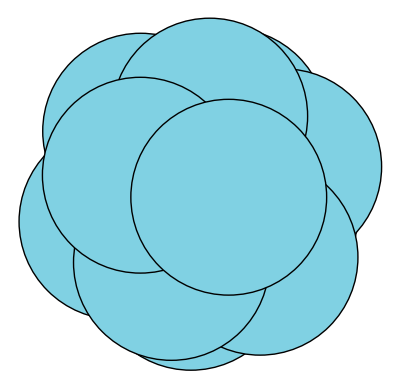

In [2]:
N_ATOMS = 13 # 13, 31, 38

lj_cluster, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
)

print(f"max_span = {max_span:.3f}")
print(f"dimensions = {dimensions}")
print(f"symbols = {symbols}")
print(f"rep = {rep}")

lj_cluster_pop = torch.from_numpy(lj_cluster.flatten())[None, :]
energy = evaluate_lj_population_torch(lj_cluster_pop)
print(f"Energy = {float(energy):.6f} eV")

lj_atoms = Atoms(symbols, lj_cluster)
plot_atoms_without_axes(lj_atoms)
### view(lj_atoms);


We always use randomized configurations as founder structures for the evolutions because we do not want to include any bias into the initialization of the algorithm. With the parameter `randomize=True` and the above chosen random seed we generate a randomized LJ-13 cluster. The same information as above is given. The energy of the founder structure is very high, since the randomization positioned some atoms very close to each other. For an interactive plot, comment in the last line `view(lj_atoms_random);`.

max_span = 1.826
dimensions = 39
symbols = Ar13
rep = LJ-13
Energy = 208937.377409 eV


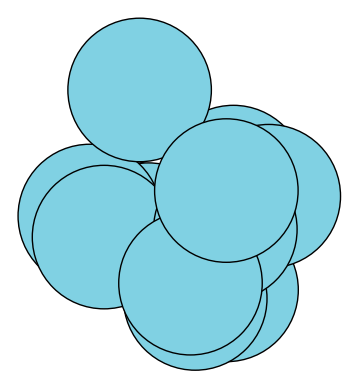

In [3]:
lj_cluster_random, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=SEED,
)

print(f"max_span = {max_span:.3f}")
print(f"dimensions = {dimensions}")
print(f"symbols = {symbols}")
print(f"rep = {rep}")

lj_cluster_random_pop = torch.from_numpy(lj_cluster_random.flatten())[None, :]
energy_random = evaluate_lj_population_torch(lj_cluster_random_pop)
print(f"Energy = {float(energy_random):.6f} eV")

lj_atoms_random = Atoms(
    symbols, np.reshape(lj_cluster_random, newshape=(-1, 3))
)
plot_atoms_without_axes(lj_atoms_random);
### view(lj_atoms_random);


### Founder

We can now start with the configuration of the evolution. First, we define the randomized LJ-13 cluster from above as the `founder` structure for our evolution.

In [4]:
# Initialize founder structure
lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=SEED,
)
founder = Atoms(symbols, np.reshape(lj_cluster_rand, newshape=(-1, 3)))


### `AtomsFixer`

Next, we initialize the `AtomsFixer` class which defines if some atoms are fixed during the evolution or not. This can be changed by adding atom indices to the `fix_list`. Since we want all atoms to be freely moveable, we use an empty list here. The printed output shows us that no atoms are fixed or freezed (i.e. atoms that are fixed during the sampling process but will be relaxed in every generation), while all 13 atoms are free. The `fix_axis` and `fix_threshold` parameters are used when fixing the bulk of a surface structure in relation to a specific axis by defining `fix_func="get_fixed_by_threshold"` (not used for the cluster examples in this tutorial).

In [5]:
# Initialize fixing parameters
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

fixed_indices, frozen_indices, free_indices = fixer.get_indices(founder)
print(fixed_indices, frozen_indices, free_indices)


[] [] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### `AtomsRelaxer`

The `AtomsRelaxer` class defines the parameters for the relaxation step. Here, we chose with `calc="LJ"` the Lennard-Jones potential as evaluation method, which will be executed on the CPU (`device="cpu"`) in a parallelized fashion (`multiproc=True`) with 16 processes (`n_proc=16`) to decrease the computation time. The termination criteria for the relaxation is either a maximum force of 0.001 eV/Å (`fmax=0.001`) or 1000 steps performed (`steps=1000`). Additionally, we do not need a logfile (`logfile=None`) and want to obeserve the progress during the evolution (`progress_bar=True`). Important is the `e_cutoff` parameter which defines the energy threshold at which a penalty factor should be used. This is only necessary when the foundation model is assigning very low energies to unphysical structures. This value can change from founder to founder and should be set by the user independently. 

In [6]:
# Initialize relaxing parameters
relaxer = AtomsRelaxer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    optimizer="FIRE",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)


### `CHARLX`

The evolutionary algorithm `CHARLX` itself is is a class derived from `CHARLES`. It is initialized, among other things, with the free positions of the founder structure `x0`, the population size `popsize` and the number of generations `n_gens`. For the conditioning we use two mechanisms, an `OriginCondition` to keep the atoms close to the origin and a `KNNNoveltyCondition` to increase the diversity of the samples. For a surface structure, the `AxisCondition` class can be used instead (not shown in this tutorial). The other parameters should only be changed if the user is sure it will improve the results. For further information on the parameters see the documentation of the `CHARLES` parent class.

In [7]:
# Initialize condition around the origin
condition_obj = OriginCondition(
    n_atoms=relaxer.free_n_atoms,
    target=1.0,
    kwargs={"cond_threshold": max_span},
)

# Initialize evolutionary algorithm
es = CHARLX
es_config = dict(
    x0=relaxer.free_positions,
    fixer=fixer,
    relaxer=relaxer,
    conditions=(condition_obj, KNNNoveltyCondition()),
    popsize=16,
    n_gens=5,
    sigma_init=1.5,
    selection_pressure=20.0,
    elite_ratio=0.15,
    crossover_ratio=0.125,
    mutation_rate=0.05,
    diff_batch_size=256,
    diff_max_epoch=1000,
    buffer_size=1000,
    is_genetic_algorithm=True,
    adaptive_selection_pressure=True,
    readaptation=False,
    forget_best=False,
)


### Neural network

Now we initialize the neural network used inside the diffusion model `GGDDIM` for the predictions. We choose the default multi-layer-perceptron `MLP` and initialize the correct number of parameters and conditions based on the choices from above.

In [8]:
# Initialize neural network
nn = "MLP"
nn_config = dict(
    num_hidden=96,
    num_layers=8,
    activation="LeakyReLU",
    num_params=relaxer.dimensions,
    num_conditions=len(es_config["conditions"]),
)


### Diffusion model

As diffusion model we use `GGDDIM`, the gradient guided version of the default implementation `DDIM`. As geometric guidance mode we choose the `radial` option, which defines in our case a sphere with radius `max_span * 1.5` positioned at the origin of the Euclidean space `diff_origin`. Futher information on the input parameters can be found both in the documentation of the `DDIM` and `GGDDIM` classes.

In [9]:
# Initialize diffusion model
diff = "GGDDIM"
diff_config = dict(
    num_steps=5000,
    lamba_range=1.0,
    geometry="radial",
    axis=None,
    lower_threshold=0.0,
    upper_threshold=max_span*1.5,
    diff_origin=[0.0, 0.0, 0.0],
    overlap_penalty=True,
    train_on_penalty=True,
)


### Objective

Finally, we need to define an objective for the evolution. Given is the objective function `evaluate_population_with_calc()` which uses `ase` calculators to evaluate the energies of the sampled configurations. We maximize the fitness of the samples, which corresponds in our case to the lowest energy structures. The `obj_params` dictionary containes all necessary encoded `AtomsRelaxer` parameter, including `e_cutoff` for the evaluation step.

In [10]:
# Initialize objective that will be maximized
obj = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="evaluate_population_with_calc",
    foo_kwargs={"obj_params": relaxer.encode_params()},
    maximize=True,
    dim=relaxer.dimensions,
)


### Run evolution

After all configurations are defined, we can execute the evolution. The `dst` variable determines in which folder the results should be saved. Here we use the `output` folder as destination and add further parameter choices to the name of the evolution folder for clarity. If a new evolution is started and a folder with the same name is already available, then this folder will be deleted. If this is not desired, comment out the line `shutil.rmtree(dst, ignore_errors=True)`. The function call `run_evo()` starts the evolution. The progress of the relaxation, evaluation and training steps are printed for every generation below, together with the maximum and average fitness values.

In [11]:
# Define destination path for output data
dst = f"output/{rep}"
dst += f"_P-{es_config["popsize"]}"
dst += f"_G-{es_config["n_gens"]}"
dst += f"_F-{relaxer.fmax}"
dst += f"_S-{relaxer.steps}"
dst += f"_U-{diff_config['upper_threshold']:.3f}"

# Remove old folder before new evolution
shutil.rmtree(dst, ignore_errors=True)

# Execute CHARLX evolution
evo = run_evo(
    generations=es_config["n_gens"],
    es=es,
    es_config=es_config,
    nn=nn,
    nn_config=nn_config,
    diff=diff,
    diff_config=diff_config,
    objective=obj,
    dst=dst,
    params={"save_diffusion": False},
)


# Loading Objective:
<class 'run.CorrectedApplyLimitsObjective'> True
-  {"dim": 39, "foo_module": "util", "foo_kwargs": {"obj_params": {"founder_atoms": "{\"numbers\": {\"__ndarray__\": [[13], \"int64\", [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]]}, \"positions\": {\"__ndarray__\": [[13, 3], \"float64\", [-0.428499794284629, -0.49828615663862164, -1.7013985743596773, -0.19979710057191227, 1.598784762410794, 0.8331323726690198, 1.1847174381394618, 0.3119204327328255, -1.0442142633377398, 1.0813332791392645, 0.11269775204546528, 1.1489449795386464, 0.6219370501216992, -1.4811731897416949, 0.1336710683957333, 1.0420980885268694, -0.6362989297258376, -0.5338030061734236, -0.7254064722399863, -0.5747208756668536, -0.14484534638636412, -0.0697898237280881, -0.5387330306925501, -1.5446476542951022, -0.9356658191588881, -0.26309185204285324, -1.106920732772873, 1.0663574228694657, -0.4608780596498079, 0.421741695136213, 0.5514634303128284, -1.2558352188689559, 0.4224854882993313, 1.

Relaxation:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 16/16 [00:45<00:00,  2.85s/it]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 320.61epoch/s, loss=0.15]


  { "Generation": 0, "Max-Fitness": 35.728981321044465, "Avg-Fitness": 26.67749141447365, "Model-Loss": 0.14961419763315284}


Relaxation:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:02<00:00, 343.91epoch/s, loss=0.195]


  { "Generation": 1, "Max-Fitness": 44.32680140706513, "Avg-Fitness": 39.76224589143004, "Model-Loss": 0.19485250091066372}


Relaxation:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]Process SpawnPoolWorker-89:
Process SpawnPoolWorker-81:
Process SpawnPoolWorker-88:
Process SpawnPoolWorker-92:
Process SpawnPoolWorker-93:
Process SpawnPoolWorker-84:
Process SpawnPoolWorker-83:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/cx/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/cx/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/cx/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/anaconda3/envs/cx/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simonpernegger/Library/CloudStorage/OneDrive-Persönlich/UNI/2_MASTER_CSE/MSC_THESIS/code/charlx_t

KeyboardInterrupt: 

### View results

To view the energies of the sampled structures, execute the `view_results()` function. The energies for the best structure of every generation is plotted below, together with the energies of all structures in a specific generation `gen`, where the last generation is chosen as default. Also visualizations of the founder structure and the best configuration of the whole evolution are given. To interactively visualize these structures, set `show=True`.

loading data from output/LJ-13_P-16_G-5_F-0.001_S-1000_U-2.738/ES_CHARLX-objective_evaluate_population_with_calc.h5
Initial Structure Energy: 208937.3774 eV


=== Evolution Strategy Config ===
x0                       : tensor([-0.4285, -0.4983, -1.7014, -0.1998,  1.5988,  0.8331,  1.1847,  0.3119,
        -1.0442,  1.0813,  0.1127,  1.1489,  0.6219, -1.4812,  0.1337,  1.0421,
        -0.6363, -0.5338, -0.7254, -0.5747, -0.1448, -0.0698, -0.5387, -1.5446,
        -0.9357, -0.2631, -1.1069,  1.0664, -0.4609,  0.4217,  0.5515, -1.2558,
         0.4225,  1.7081,  0.0294,  0.4052,  1.0844, -1.3552, -0.4152])
fixer                    : AtomsFixer(fix_func=get_fixed_by_list, fix_list=[], fix_axis=None, fix_threshold=None, freeze_func=None, freeze_list=[], freeze_axis=None, freeze_threshold=None, fix_center=None, fix_radius=None)
relaxer                  : AtomsRelaxer(founder_atoms=Atoms(symbols='Ar13', pbc=False), fixed_indices=[], frozen_indices=[], free_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8,

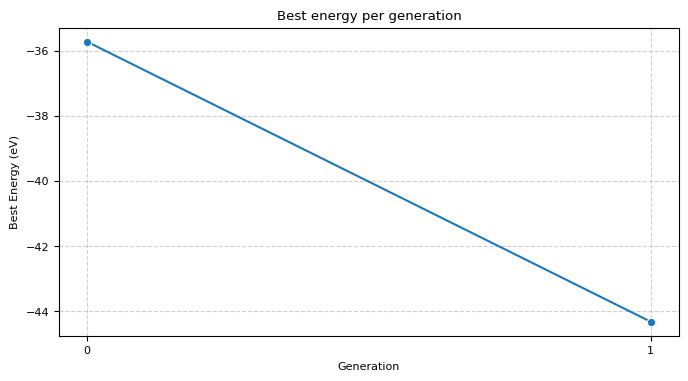

,Results
Initial energy (eV),208937.377409
Final best energy (eV),-44.326801
"Improvement vs initial (ΔE, eV)",208981.704210
Global best energy (eV),-44.326801
Best generation (1-based),2.000000
Generations run,2.000000


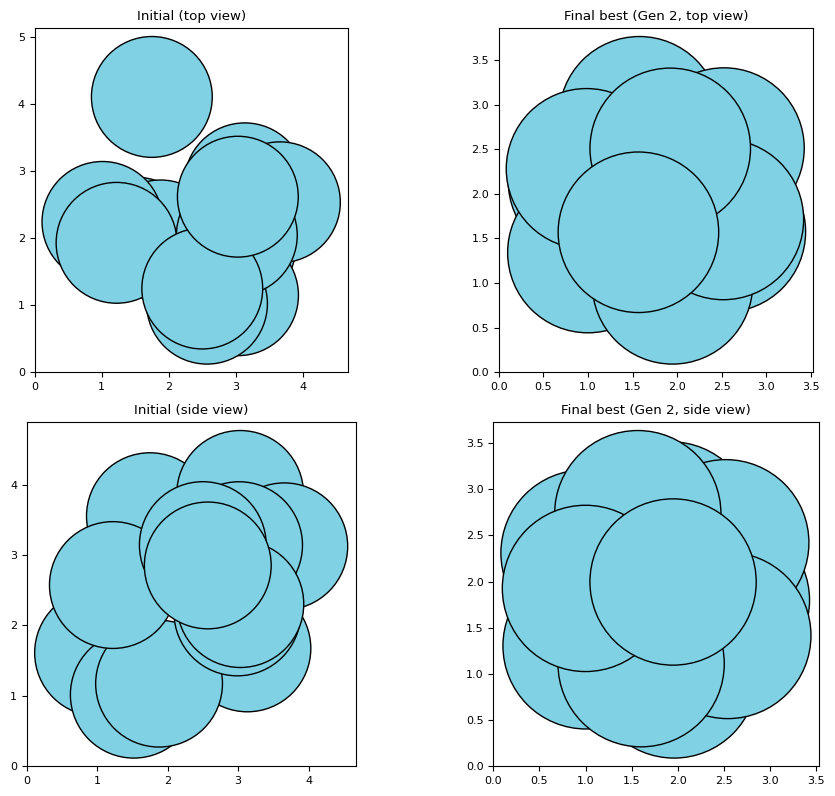

In [12]:
# Analyze output energies and structures
view_results(dst=dst, sort_samples=True, show=False)


## 2. Gold (Au) cluster

The second example is a CHARLX evolution of the gold cluster with 13 atoms (Au-13). The same functionality as for the LJ-13 cluster is used to generate the randomized founder, but now with gold atoms (`element="Au"`). For an interactive plot, comment in the last line `view(au_random_atoms);`.

max_span = 1.826
dimensions = 39
symbols = Au13
rep = Au-13


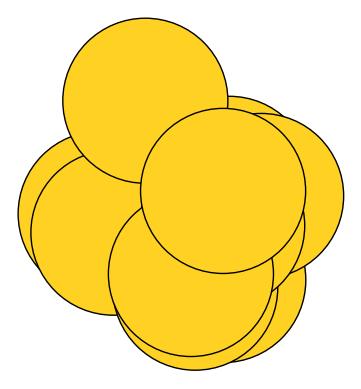

In [13]:
au_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=13,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=SEED,
    element="Au",
    name="Au",
)

print(f"max_span = {max_span:.3f}")
print(f"dimensions = {dimensions}")
print(f"symbols = {symbols}")
print(f"rep = {rep}")

au_random_atoms = Atoms(symbols, np.reshape(au_cluster_rand, newshape=(-1, 3)))
plot_atoms_without_axes(au_random_atoms);
### view(au_random_atoms);


### Configurate evolution

The same configuration steps are performed as for the LJ-13 cluster. Differences are chosen for the `element` and `name` parameters in the `load_lj_cluster()` function to generate a gold cluster; for the `calc`, `multiproc`, `n_proc` and `device` parameters in the `AtomsRelaxer` class to use the OMAT foundation model on the GPU for the evaluation; and the `geometry` and `upper_threshold` parameters in the `GGDDIM` configuration to use the elliposiodal geometry guidance instead of the radial one. The `calc` parameter needs to be changed to the path where the foundation model is saved. The `steps` parameter was decreased significantly to reduce the computation time for presentation purposes. For useful results, a value around `steps=1000` is recommended.

In [ ]:
# Initialize founder structure
au_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=13,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=SEED,
    element="Au",
    name="Au",
)
founder = Atoms(symbols, np.reshape(au_cluster_rand, newshape=(-1, 3)))

# Initialize fixing parameters
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

# Initialize relaxing parameters
relaxer = AtomsRelaxer(
    founder_atoms=founder,
    fixer=fixer,
    calc="model/mace-omat-0-medium.model",
    optimizer="FIRE",
    fmax=0.001,
    steps=10, # 1000,
    logfile=None,
    multiproc=False,
    n_proc=None,
    device="cuda",
    e_cutoff=-500,
    progress_bar=True,
)

# Initialize condition around the origin
condition_obj = OriginCondition(
    n_atoms=relaxer.free_n_atoms,
    target=1.0,
    kwargs={"cond_threshold": max_span},
)

# Initialize evolutionary algorithm
es = CHARLX
es_config = dict(
    x0=relaxer.free_positions,
    fixer=fixer,
    relaxer=relaxer,
    conditions=(condition_obj, KNNNoveltyCondition()),
    popsize=16,
    n_gens=5,
    sigma_init=1.5,
    selection_pressure=20.0,
    elite_ratio=0.15,
    crossover_ratio=0.125,
    mutation_rate=0.05,
    diff_batch_size=256,
    diff_max_epoch=1000,
    buffer_size=1000,
    is_genetic_algorithm=True,
    adaptive_selection_pressure=True,
    readaptation=False,
    forget_best=False,
)

# Initialize neural network
nn = "MLP"
nn_config = dict(
    num_hidden=96,
    num_layers=8,
    activation="LeakyReLU",
    num_params=relaxer.dimensions,
    num_conditions=len(es_config["conditions"]),
)

# Initialize diffusion model
diff = "GGDDIM"
diff_config = dict(
    num_steps=5000,
    lamba_range=1.0,
    geometry="ellipsoid",
    axis=None,
    lower_threshold=0.0,
    upper_threshold=list(max_span * np.array([1.5, 1.5, 3.0])),
    diff_origin=[0.0, 0.0, 0.0],
    overlap_penalty=True,
    train_on_penalty=True,
)

# Initialize objective that will be maximized
obj = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="evaluate_population_with_calc",
    foo_kwargs={"obj_params": relaxer.encode_params()},
    maximize=True,
    dim=relaxer.dimensions,
)


Using head default out of ['default']


### Run evolution

Now we can run the evolution for the gold cluster.

In [15]:
# Define destination path for output data
dst = f"output/{rep}"
dst += f"_P-{es_config["popsize"]}"
dst += f"_G-{es_config["n_gens"]}"
dst += f"_F-{relaxer.fmax}"
dst += f"_S-{relaxer.steps}"
dst += f"_U-{diff_config['upper_threshold'][0]:.3f}"
dst += f"-{diff_config['upper_threshold'][1]:.3f}"
dst += f"-{diff_config['upper_threshold'][2]:.3f}"

# Remove old folder before new evolution
shutil.rmtree(dst, ignore_errors=True)

# Execute CHARLX evolution
evo = run_evo(
    generations=es_config["n_gens"],
    es=es,
    es_config=es_config,
    nn=nn,
    nn_config=nn_config,
    diff=diff,
    diff_config=diff_config,
    objective=obj,
    dst=dst,
    params={"save_diffusion": False},
)


# Loading Objective:
<class 'foobench.objective.Objective'> True
-  {"dim": 39, "foo_module": "util", "foo_kwargs": {"obj_params": {"founder_atoms": "{\"numbers\": {\"__ndarray__\": [[13], \"int64\", [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]]}, \"positions\": {\"__ndarray__\": [[13, 3], \"float64\", [-0.428499794284629, -0.49828615663862164, -1.7013985743596773, -0.19979710057191227, 1.598784762410794, 0.8331323726690198, 1.1847174381394618, 0.3119204327328255, -1.0442142633377398, 1.0813332791392645, 0.11269775204546528, 1.1489449795386464, 0.6219370501216992, -1.481173189741695, 0.1336710683957333, 1.0420980885268694, -0.6362989297258375, -0.5338030061734235, -0.7254064722399861, -0.5747208756668536, -0.14484534638636432, -0.0697898237280881, -0.5387330306925501, -1.5446476542951022, -0.9356658191588881, -0.26309185204285324, -1.106920732772873, 1.0663574228694654, -0.4608780596498078, 0.42174169513621296, 0.5514634303128283, -1.2558352188689557, 0.4224854882993309, 1.7080

Relaxation: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Using head default out of ['default']


100%|██████████| 1000/1000 [00:02<00:00, 409.75it/s]

  { "Generation": 0, "Max-Fitness": 19.022959390764118, "Avg-Fitness": -30.4898269797876, "Model-Loss": 0.349702928511516}



Relaxation: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


Using head default out of ['default']


100%|██████████| 1000/1000 [00:02<00:00, 471.10it/s]

  { "Generation": 1, "Max-Fitness": 26.610103430494455, "Avg-Fitness": -373981795.2611615, "Model-Loss": 0.14991524222274166}



Relaxation: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


Using head default out of ['default']


100%|██████████| 1000/1000 [00:02<00:00, 443.34it/s]

  { "Generation": 2, "Max-Fitness": 27.947568787418405, "Avg-Fitness": -38293804090.8293, "Model-Loss": 0.1760693097701063}



Relaxation: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Using head default out of ['default']


100%|██████████| 1000/1000 [00:02<00:00, 436.09it/s]

  { "Generation": 3, "Max-Fitness": 28.441353809504044, "Avg-Fitness": -25924488527.92153, "Model-Loss": 0.31991831748702876}



Relaxation: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


Using head default out of ['default']


100%|██████████| 1000/1000 [00:02<00:00, 447.55it/s]

  { "Generation": 4, "Max-Fitness": 28.75041070987995, "Avg-Fitness": -19252153616.632008, "Model-Loss": 0.22704800495271507}
  { "Generation": 4, "Max-Fitness": 28.75041070987995, "Avg-Fitness": -19252153616.632004, "Model-Loss": 0.22704800495271507}


### View results

Use the `view_results()` function for visualization of the sampled configurations.

loading data from output/Au-13_P-16_G-5_F-0.001_S-10_U-2.738-2.738-5.477/ES_CHARLX-objective_evaluate_population_with_calc.h5
Using head default out of ['default']
Initial Structure Energy: -1627.2999 eV


=== Evolution Strategy Config ===
x0                       : tensor([-0.4285, -0.4983, -1.7014, -0.1998,  1.5988,  0.8331,  1.1847,  0.3119,
        -1.0442,  1.0813,  0.1127,  1.1489,  0.6219, -1.4812,  0.1337,  1.0421,
        -0.6363, -0.5338, -0.7254, -0.5747, -0.1448, -0.0698, -0.5387, -1.5446,
        -0.9357, -0.2631, -1.1069,  1.0664, -0.4609,  0.4217,  0.5515, -1.2558,
         0.4225,  1.7081,  0.0294,  0.4052,  1.0844, -1.3552, -0.4152])
fixer                    : AtomsFixer(fix_func=get_fixed_by_list, fix_list=[], fix_axis=None, fix_threshold=None, freeze_func=None, freeze_list=[], freeze_axis=None, freeze_threshold=None, fix_center=None, fix_radius=None)
relaxer                  : AtomsRelaxer(founder_atoms=Atoms(symbols='Au13', pbc=False), fixed_indices=[], frozen_indic

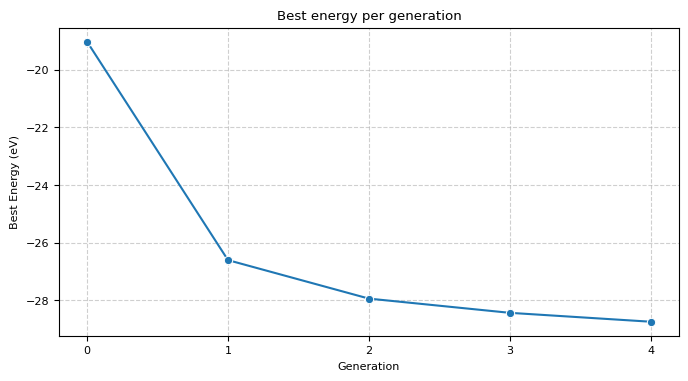

,Results
Initial energy (eV),-1627.299856
Final best energy (eV),-28.750411
"Improvement vs initial (ΔE, eV)",-1598.549445
Global best energy (eV),-28.750411
Best generation (1-based),5.000000
Generations run,5.000000


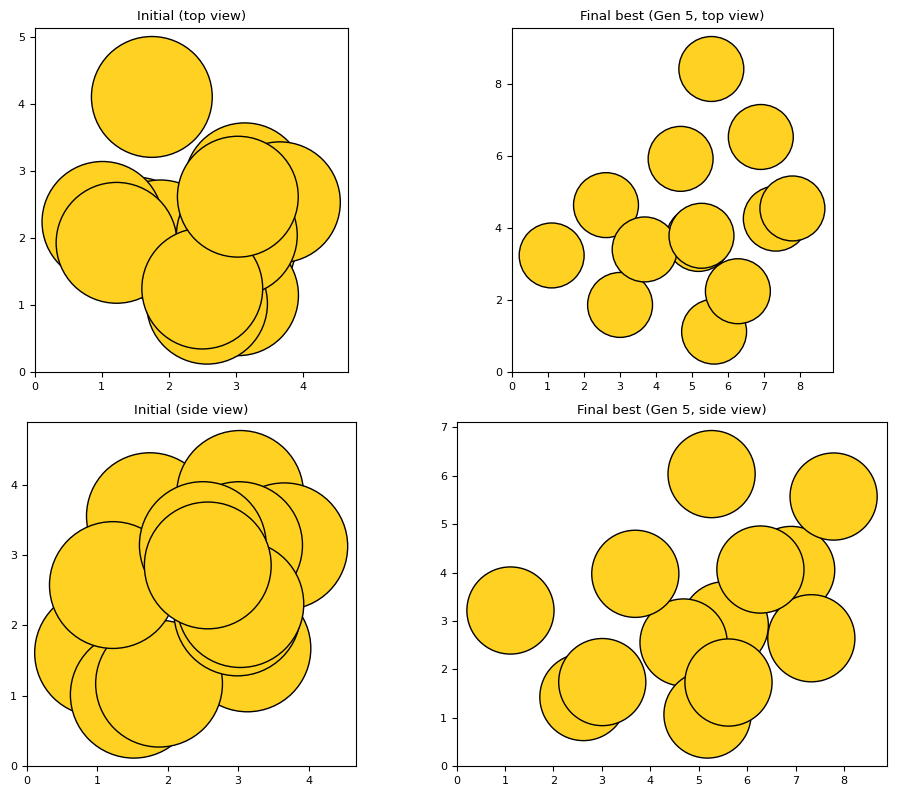

In [16]:
# Analyze output energies and structures
view_results(dst=dst, sort_samples=True, show=False)
